In [1]:
%load_ext autoreload
%autoreload 2

import wandb
import math
import timeit
from tqdm import tqdm
import json

import os
import os.path as osp
from pathlib import Path
import numpy as np

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader

from torch_geometric.nn import TransformerConv

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# internal imports
from tgb.utils.utils import *
from tgb.linkproppred.evaluate import Evaluator
from modules.decoder import LinkPredictorTGNPL
from modules.emb_module import GraphAttentionEmbedding
from modules.msg_func import TGNPLMessage
from modules.inventory_module import TGNPLInventory
from modules.msg_agg import *
from modules.neighbor_loader import LastNeighborLoaderTGNPL
from modules.memory_module import TGNPLMemory, StaticMemory
from modules.early_stopping import  EarlyStopMonitor
from modules.hyper_edgebank import HyperEdgeBankPredictor, test_edgebank

from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset, PyGLinkPropPredDatasetHyper
from tgnpl import *

# Data Exploration

In [2]:
DATA = 'tgbl-sync-large'
with open(f"/home/demi/supply-chains/TGB/tgb/datasets/{DATA.replace('-', '_')}/{DATA}_meta.json","r") as file:
    METADATA = json.load(file)
    NUM_NODES = len(METADATA["id2entity"])
METADATA.keys()

dict_keys(['product_threshold', 'id2entity', 'train_max_ts', 'val_max_ts', 'test_max_ts'])

In [3]:
NUM_FIRMS = METADATA["product_threshold"]
NUM_PRODUCTS = NUM_NODES - NUM_FIRMS
NUM_FIRMS, NUM_PRODUCTS

(401, 996)

In [4]:
METADATA['train_max_ts']

137

In [5]:
METADATA['val_max_ts']

168

In [6]:
METADATA['test_max_ts']

199

In [7]:
# load dataset
device = "cpu"
dataset = PyGLinkPropPredDatasetHyper(name=DATA, root="datasets", use_prev_sampling=False)
train_mask = dataset.train_mask
val_mask = dataset.val_mask
test_mask = dataset.test_mask
data = dataset.get_TemporalData()
data = data.to(device)

# for evaluation
neg_sampler = dataset.negative_sampler
dataset.load_val_ns()  # load validation negative samples
metric = dataset.eval_metric
evaluator = Evaluator(name=DATA)

Dataset tgbl-sync-large url not found, download not supported yet.
file found, skipping download
Dataset directory is  /home/demi/supply-chains/TGB/tgb/datasets/tgbl_sync_large
loading processed file


## Training time check

In [70]:
# load saved model - model with highest MRR
model_path = 'TGNPL_tgbl-sync-large_0.0003_800_10_100_1_100_10_100_1e-06_300.0_1_False_False_False_static_id_False_10_1_10.0_0_100_False_False_2024_02_17-12_13_59_0_final.pth'
model_path = os.path.join('saved_models', model_path)
before_change_checkpoint = torch.load(model_path)

In [71]:
before_change_checkpoint.keys()

dict_keys(['memory', 'gnn', 'link_pred'])

In [74]:
before_change_checkpoint['memory']['last_update']

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

# Full experiment results - Time sensitive analysis

In [75]:
# hyperedge bank baseline
# entire time
exist_baseline = 0.1821916550397873 
count_baseline = 0.5235551595687866

In [123]:
fn = 'TGNPL_tgbl-sync-large_0.0003_800_10_200_1_100_10_100_1e-06_300.0_1_False_False_False_tgnpl_sum_False_10_1_10.0_0_-1_False_False_2024_02_11-17_31_49_results.json'
fn = os.path.join('saved_results', fn)
with open(fn, 'r') as f:
    results = json.load(f)
train_loss_tgnpl_sync_all_sum_100, val_mrr_tgnpl_sync_all_sum_100, test_mrr = results['train loss'], results['val mrr'], results.get('test mrr', -1)

In [117]:
val_mrr_tgnpl_sync_before_attn[-1],test_mrr

(0.26026734709739685, 0.6182916760444641)

(0.0, 100.0)

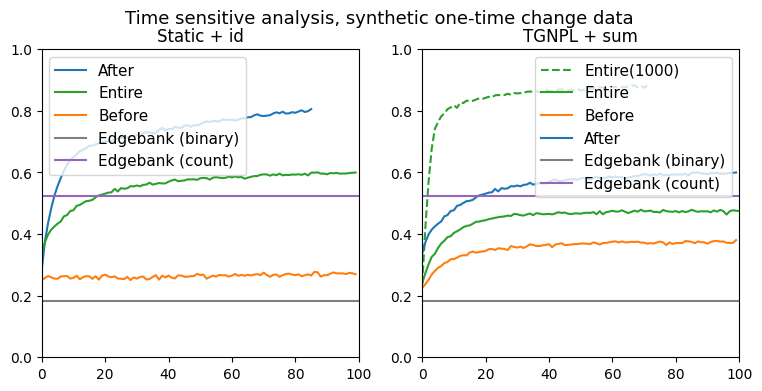

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle('Time sensitive analysis, synthetic one-time change data', fontsize=13)
baseline = torch.nn.CrossEntropyLoss()(torch.ones(1, 19), torch.tensor([0]))
#axes[0].plot([0, 45], [baseline, baseline], label='same score', color='grey')
axes[0].set_title("Static + id")
axes[0].plot(val_mrr_static_sync_after_id, label = 'After', color = 'tab:blue')
axes[0].plot(val_mrr_static_sync_all_id[0:100], label = 'Entire', color = 'tab:green')
axes[0].plot(val_mrr_static_sync_before_id, label = 'Before', color = 'tab:orange')
axes[0].plot([0, 100], [exist_baseline, exist_baseline], label='Edgebank (binary)', color='tab:grey')
axes[0].plot([0, 100], [count_baseline, count_baseline], label='Edgebank (count)', color='tab:purple')
axes[0].legend(fontsize=11)
axes[0].set_ylim([0, 1])

axes[1].set_title("TGNPL + sum")
axes[1].plot(val_mrr_tgnpl_sync_all_sum, label='Entire(1000)', color='tab:green', linestyle = '--')
axes[1].plot(val_mrr_tgnpl_sync_all_sum_100, label='Entire', color='tab:green')
axes[1].plot(val_mrr_tgnpl_sync_before_sum[0:100], label='Before', color='tab:orange')
#axes[1].plot(val_mrr_static_sum_30[0:35], label='after change',color='tab:orange')
#axes[1].plot(val_mrr_static_id_100, label='tgnpl+sum+ before time',color='tab:purple')
axes[1].plot(val_mrr_static_sync_all_id, label='After',color='tab:blue')
#axes[1].plot(val_mrr_tgnpl_sum_30, label='tgnpl+sum+after time',color='tab:blue')
axes[1].plot([0, 100], [exist_baseline, exist_baseline], label='Edgebank (binary)', color='tab:grey')
axes[1].plot([0, 100], [count_baseline, count_baseline], label='Edgebank (count)', color='tab:purple')
axes[1].legend(fontsize=11)
axes[1].set_ylim([0, 1])
axes[1].set_xlim([0, 100])

(0.0, 100.0)

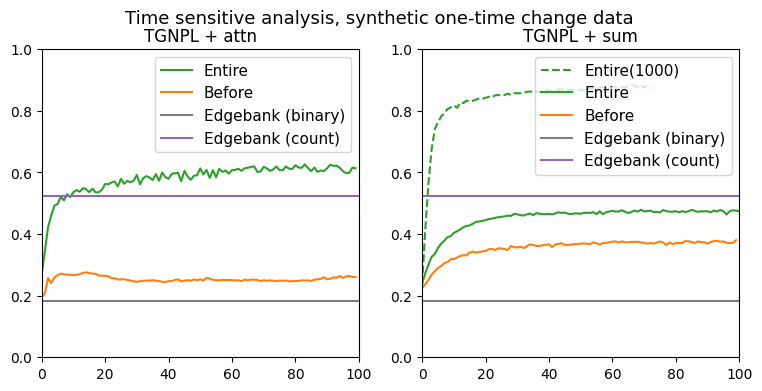

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle('Time sensitive analysis, synthetic one-time change data', fontsize=13)
baseline = torch.nn.CrossEntropyLoss()(torch.ones(1, 19), torch.tensor([0]))
#axes[0].plot([0, 45], [baseline, baseline], label='same score', color='grey')
axes[0].set_title("TGNPL + attn")
#axes[0].plot(val_mrr_tgnpl_sync_after_attn, label = 'After', color = 'tab:green')
axes[0].plot(val_mrr_tgnpl_sync_all_attn[0:100], label = 'Entire', color = 'tab:green')
axes[0].plot(val_mrr_tgnpl_sync_before_attn, label = 'Before', color = 'tab:orange')
axes[0].plot([0, 100], [exist_baseline, exist_baseline], label='Edgebank (binary)', color='tab:grey')
axes[0].plot([0, 100], [count_baseline, count_baseline], label='Edgebank (count)', color='tab:purple')
axes[0].legend(fontsize=11)
axes[0].set_ylim([0, 1])

axes[1].set_title("TGNPL + sum")
axes[1].plot(val_mrr_tgnpl_sync_all_sum, label='Entire(1000)', color='tab:green', linestyle = '--')
axes[1].plot(val_mrr_tgnpl_sync_all_sum_100, label='Entire', color='tab:green')
axes[1].plot(val_mrr_tgnpl_sync_before_sum[0:100], label='Before', color='tab:orange')
#axes[1].plot(val_mrr_static_sum_30[0:35], label='after change',color='tab:orange')
#axes[1].plot(val_mrr_static_id_100, label='tgnpl+sum+ before time',color='tab:purple')
#axes[1].plot(val_mrr_static_sync_all_id, label='After',color='tab:blue')
#axes[1].plot(val_mrr_tgnpl_sum_30, label='tgnpl+sum+after time',color='tab:blue')
axes[1].plot([0, 100], [exist_baseline, exist_baseline], label='Edgebank (binary)', color='tab:grey')
axes[1].plot([0, 100], [count_baseline, count_baseline], label='Edgebank (count)', color='tab:purple')
axes[1].legend(fontsize=11)
axes[1].set_ylim([0, 1])
axes[1].set_xlim([0, 100])

## Why TGNPL + attn better than TGNPL + sum with the same emb size?

in attn embs, we have time emb to encode last time change, we can try to modify that part and to see how the model been changed.

see the code following:

class GraphAttentionEmbedding(torch.nn.Module):
    """
    Reference:
    - https://github.com/pyg-team/pytorch_geometric/blob/master/examples/tgn.py
    Our changes: added second convolutional layer since we have bipartite graph,
    added batch norm.
    """

    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv1 = TransformerConv(
            in_channels, out_channels // 2, heads=2, dropout=0.5, edge_dim=edge_dim
        )
        self.bns = BatchNorm1d(out_channels)
        self.relu = ReLU()
        self.conv2 = TransformerConv(
            out_channels, out_channels // 2, heads=2, dropout=0.5, edge_dim=edge_dim
        )

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype)) #we can may drop this 
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bns(x)
        x = self.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        return x
    
    
class GraphSumEmbedding(torch.nn.Module):
    """
    Simpler GNN embedding that uses GraphConv and sum aggregation.
    Similar to Temporal Graph Sum from TGN.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GraphConv(in_channels, out_channels, aggr="add")
        self.bns = BatchNorm1d(out_channels)
        self.relu = ReLU()
        self.dropout = Dropout(p=0.5, inplace=False)
        self.conv2 = GraphConv(out_channels, out_channels, aggr="add")

    def forward(self, x, last_update, edge_index, t, msg):
        x = self.conv1(x, edge_index)
        x = self.bns(x)
        x = self.relu(x)
        if self.training:
            x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

## Attention weights analysis 